In [1]:
import os
os.getcwd()

os.chdir("E:\\Studies\\TU Berlin\\Thesis\\autoencoders_keras-master\\Python")

os.getcwd()

'E:\\Studies\\TU Berlin\\Thesis\\autoencoders_keras-master\\Python'

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed

from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard


from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [4]:
seed(10)
set_random_seed(10)

In [5]:
first = '../../dataset/ims/1st_test'
second = '../../dataset/ims/2nd_test'
third = '../../dataset/ims/4th_test/txt'

In [8]:
def readData(dataDir, setName,set1=False):
    files = os.listdir(dataDir)
    print("Number of files:",len(files))
    
    bearing1= list()
    bearing2= list()
    bearing3= list()
    bearing4= list()

    bearing_list = {setName+"_bearing-1" : bearing1,setName+"_bearing-2" : bearing2,setName+"_bearing-3" : bearing3,setName+"_bearing-4" : bearing4}
    
    cols=['bearing-1','bearing-2','bearing-3','bearing-4']
    
    for filename in files:

        dataset=pd.read_csv(os.path.join(dataDir, filename), sep='\t', header=None, names=cols)

        avg_df = dataset.groupby(dataset.index // 5).mean()
        
        for bearing in cols:
            dict_key = setName+"_"+bearing
            if dict_key in bearing_list:
                b = pd.DataFrame(avg_df[bearing]).T
                bearing_list[setName+"_"+bearing].append(b)
    
    return bearing_list

In [10]:
data = readData(second, "S2")
for bearing in set2:
    print(bearing,len(data[bearing]))

Number of files: 984
S2_bearing-1 984
S2_bearing-2 984
S2_bearing-3 984
S2_bearing-4 984


In [46]:
# split data into training and test set

In [11]:
bearing1 = pd.concat(data["S2_bearing-1"])

train = bearing1.iloc[0:688]
test = bearing1.iloc[688:]
train.reset_index(drop= True, inplace=True)
test.reset_index(drop= True, inplace=True)
print(train.shape, test.shape)

(688, 4096) (296, 4096)


In [14]:
# Standardarize train and test set
scaler = preprocessing.StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train))
test_scaled = pd.DataFrame(scaler.transform(test))
print(train_scaled.shape, test_scaled.shape)

(688, 4096) (296, 4096)


In [49]:
# prepare data for LSTM

In [15]:
def temporalize(X, lookback):
    output_X = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
    return output_X


def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [17]:
n_features = train_scaled.shape[1] 
lookback = 20  

# Temporalize the data
X = temporalize(X = train_scaled.values, lookback = lookback)
X_t = temporalize(X = test_scaled.values, lookback = lookback)

667 275


In [18]:
X_train_lstm = np.array(X)
X_test_lstm = np.array(X_t)
X_train = X_train_lstm.reshape(X_train_lstm.shape[0], lookback, n_features)
X_test = X_test_lstm.reshape(X_test_lstm.shape[0], lookback, n_features)
print(X_train.shape, X_test.shape)

(667, 20, 1, 4096) (275, 20, 1, 4096)


In [55]:
# LSTM AE Anomaly Detector

In [24]:
timesteps =  X_train.shape[1] # equal to the lookback=20
n_features =  X_train.shape[2] # 4096

epochs = 100
batch = 64
lr = 0.001

In [27]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(600, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(250, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(250, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(600, activation='tanh', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 20, 600)           11272800  
_________________________________________________________________
lstm_10 (LSTM)               (None, 250)               851000    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 20, 250)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 250)           501000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 20, 600)           2042400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 4096)          2461696   
Total params: 17,128,896
Trainable params: 17,128,896
Non-trainable params: 0
__________________________________________

In [28]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_split=0.08,
                                                verbose=2).history


Train on 613 samples, validate on 54 samples
Epoch 1/100
 - 8s - loss: 0.9925 - val_loss: 1.0637
Epoch 2/100
 - 4s - loss: 0.9862 - val_loss: 1.0642
Epoch 3/100
 - 5s - loss: 0.9772 - val_loss: 1.0609
Epoch 4/100
 - 5s - loss: 0.9723 - val_loss: 1.0628
Epoch 5/100
 - 4s - loss: 0.9673 - val_loss: 1.0622
Epoch 6/100
 - 4s - loss: 0.9622 - val_loss: 1.0619
Epoch 7/100
 - 5s - loss: 0.9568 - val_loss: 1.0628
Epoch 8/100
 - 4s - loss: 0.9513 - val_loss: 1.0717
Epoch 9/100
 - 5s - loss: 0.9453 - val_loss: 1.0678
Epoch 10/100
 - 5s - loss: 0.9431 - val_loss: 1.0885
Epoch 11/100
 - 5s - loss: 0.9608 - val_loss: 1.0779
Epoch 12/100
 - 4s - loss: 0.9741 - val_loss: 1.0747
Epoch 13/100
 - 4s - loss: 0.9914 - val_loss: 1.0707
Epoch 14/100
 - 4s - loss: 0.9956 - val_loss: 1.0717
Epoch 15/100
 - 4s - loss: 0.9952 - val_loss: 1.0704
Epoch 16/100
 - 4s - loss: 0.9929 - val_loss: 1.0709
Epoch 17/100
 - 5s - loss: 0.9943 - val_loss: 1.0688
Epoch 18/100
 - 5s - loss: 0.9937 - val_loss: 1.0726
Epoch 19/

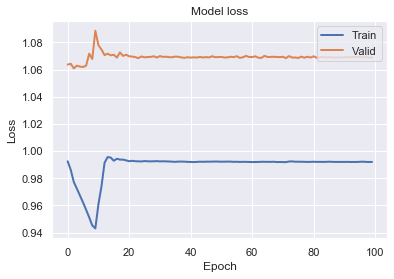

In [29]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [30]:
X_pred_train = lstm_autoencoder.predict(np.array(X_train))
X_pred_train = pd.DataFrame(flatten(X_pred_train))

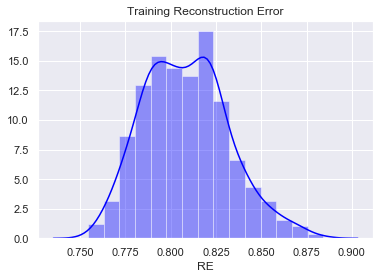

In [50]:
scored = pd.DataFrame(index=X_pred_train.index)
scored['RE'] = np.mean(np.abs(X_pred_train - flatten(X_train)), axis = 1)
plt.figure()
sns.distplot(scored['RE'],
             bins = 15, 
             kde= True,
            color = 'blue');
plt.title("Training Reconstruction Error")
plt.savefig("RE_medium")

In [63]:
scored.describe()

,Loss_mae
count,667.000000
mean,0.808511
std,0.021695
min,0.757199
25%,0.792314
50%,0.806773
75%,0.821853
max,0.884267


In [51]:
X_pred_test = lstm_autoencoder.predict(np.array(X_test))
X_pred_test = pd.DataFrame(flatten(X_pred_test))

(275, 20, 4096)
(275, 4096)


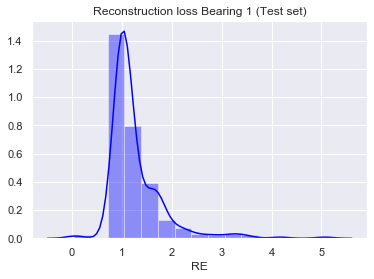

In [55]:
scored_test = pd.DataFrame(index=X_pred_test.index)
scored_test['RE'] = np.mean(np.abs(X_pred_test2 - flatten(X_test)), axis = 1)
plt.figure()
sns.distplot(scored_test['RE'],bins = 15, kde= True,color = 'blue')
plt.title("Reconstruction loss Bearing 1 (Test set)")
plt.savefig("RE_test")

In [60]:
scored_test['Threshold'] = 1.0
scored_test['Anomaly'] = scored_test2['RE'] > scored_test['Threshold']

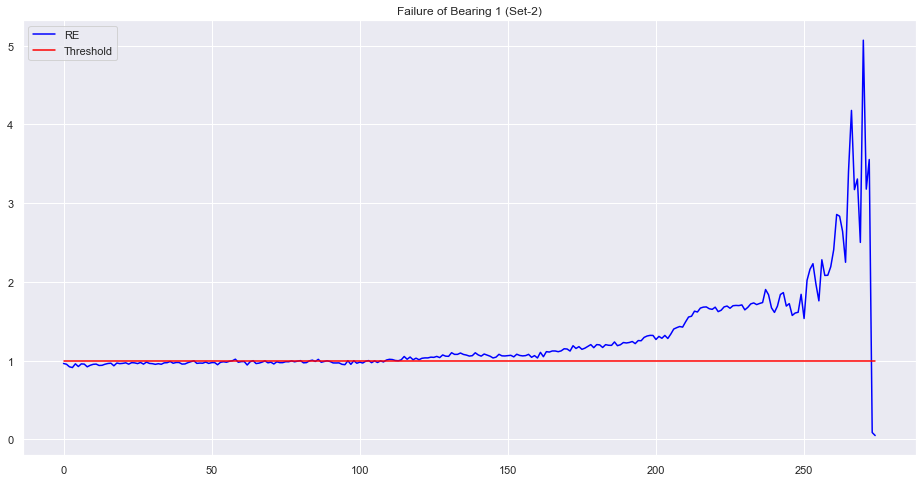

In [61]:
scored_test.plot(figsize = (16,8), color = ['blue','red'],title="Failure of Bearing 1 (Set-2)")